In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

from tqdm import tqdm

In [75]:
### load signals and the model
load_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210904_aws_clustered_filters'

file = os.path.join(load_dir, 'rot_signals.npy')
signals = np.load(file)

file = os.path.join(load_dir, 'rot_cluster_model.pkl')
with open(file, "rb") as f:
    model = pickle.load(f)

In [76]:
# for temporal CC I have 500 tp giving 10 sec, or 20ms timesteps
# here for aws model, I have 40 tp giving 4sec, or 100ms timesteps

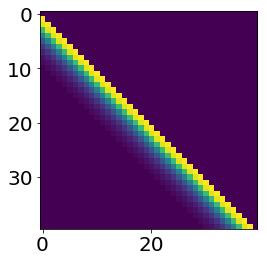

In [77]:
###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 10, 1)
y = fit_eq(x, 1, 4, -1, 8/5, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 30), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*40)
plt.imshow(toe)

In [78]:
sums = np.sum(signals,axis=-1)
to_delete = np.where(sums==0)[0]
signals_for_clustering = np.delete(signals, to_delete,axis=0)
# normalize
maxs = np.max(np.abs(signals_for_clustering),axis=-1)
signals_for_clustering = signals_for_clustering/maxs[:,np.newaxis]
signals_for_clustering.shape

(41020, 40)

In [79]:
# deconvolve
deconv = np.linalg.lstsq(toe, signals_for_clustering.T)[0]

In [88]:
# Remove edge artifact
deconv[:2,:] = deconv[2,:]
deconv[-2:,:] = deconv[-2,:]

In [89]:
# renormalize
maxs = np.max(np.abs(deconv.T),axis=-1)
signals_for_clustering = deconv.T/maxs[:,np.newaxis]
signals_for_clustering.shape

(41020, 40)

In [ ]:
# here 20ms per bin, so 250ms wide is 12bins

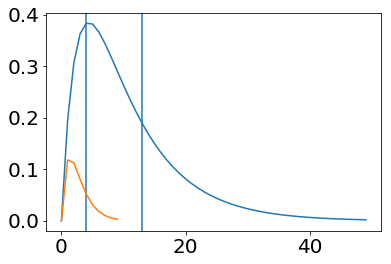

In [52]:
x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)
filter_ = y*-1
plt.plot(filter_)
plt.axvline(4)
plt.axvline(1+12)
x = np.arange(0, 10, 1)
y = fit_eq(x, 1, 4, -1, 8/5, 0)
filter_ = y*-1
plt.plot(filter_)

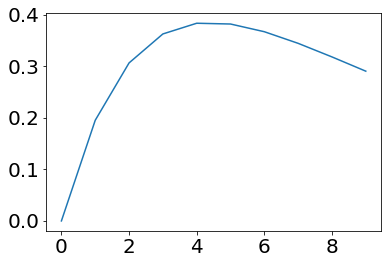

In [19]:
x = np.arange(0, 10, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)
filter_ = y*-1
plt.plot(filter_)

In [82]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [42]:
colors1 = plt.cm.Blues_r(np.linspace(0, 1, 10))
colors2 = plt.cm.Reds(np.linspace(0, 1, 10))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [52]:
import matplotlib

In [60]:
blue_gray_red_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","gray","blue"])

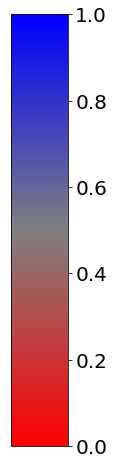

In [61]:
a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=blue_gray_red_cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

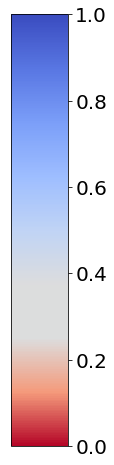

In [105]:
end = 26
start = 17
middle = 20

colors1 = plt.cm.coolwarm_r(np.linspace(0, .5, middle-start))
colors2 = plt.cm.coolwarm_r(np.linspace(.5, 1, end-middle))
spectral_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1, colors2)))

a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=spectral_map)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

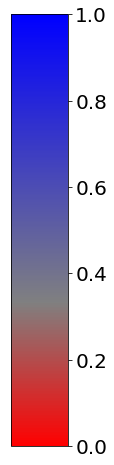

In [149]:
cvals  = [15, 20, 30]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), ["red","grey","blue"]))
blue_gray_red_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=blue_gray_red_cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

In [156]:
# need to map peak int to this color bar
# 15 -> 0, 30 ->1
(num-15)/(30-15)


0.3333333333333333

In [106]:
###############
n_clusters = 8
###############

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

### mean cluster responses
cluster_responses = []
for n in np.unique(cluster_ids):
    cluster_response = np.mean(signals_for_clustering[cluster_ids==n,:], axis=0)
    cluster_responses.append(cluster_response)
    
### peak time of clusters (for determining color)
cluster_peak_times = []
for n in range(len(np.unique(cluster_ids))):
    clus_max = np.max(cluster_responses[n])
    clus_min = np.abs(np.min(cluster_responses[n]))
    if clus_max>clus_min:
        max_value_time = np.argmax(cluster_responses[n])
    else:
        max_value_time = np.argmin(cluster_responses[n])
    cluster_peak_times.append(max_value_time)

    
### Create the same # of colors as # of clusters
#custom_cmap = cm.jet(np.linspace(0, 1, n_clusters))
#custom_cmap = blue_gray_red_cmap(np.linspace(0, 1, n_clusters))

custom_cmap = spectral_map([(n-start)/(end-start) for n in cluster_peak_times])

cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors)

In [174]:
cluster_peak_times

[22, 22, 25, 29, 26, 18, 17, 24]

In [110]:
[n/40 for n in cluster_peak_times]

[0.55, 0.55, 0.625, 0.725, 0.65, 0.45, 0.425, 0.6]

In [107]:
np.linspace(0, 1, n_clusters)

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        ])

In [106]:
cluster_peak_times

[22, 22, 25, 29, 26, 18, 17, 24]

In [105]:
np.argsort(cluster_peak_times)

array([6, 5, 0, 1, 7, 2, 4, 3])

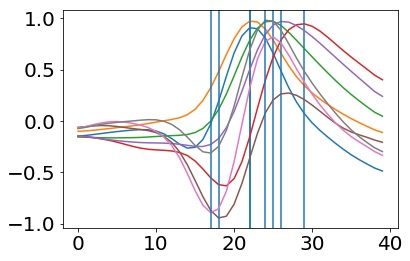

In [104]:
for n in range(len(np.unique(cluster_ids))):
    plt.plot(cluster_responses[n])
    plt.axvline(cluster_peak_times[n])

In [71]:
custom_cmap

array([[1.        , 0.        , 0.        , 1.        ],
       [0.85937716, 0.1417301 , 0.1417301 , 1.        ],
       [0.71484814, 0.28739715, 0.28739715, 1.        ],
       [0.5742253 , 0.42912726, 0.42912726, 1.        ],
       [0.42912726, 0.42912726, 0.5742253 , 1.        ],
       [0.28739715, 0.28739715, 0.71484814, 1.        ],
       [0.1417301 , 0.1417301 , 0.85937716, 1.        ],
       [0.        , 0.        , 1.        , 1.        ]])

In [70]:
cluster_colors

['#ff0000',
 '#db2424',
 '#b64949',
 '#926d6d',
 '#6d6d92',
 '#4949b6',
 '#2424db',
 '#0000ff']

In [107]:

    
cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

#add_deleted_voxels = np.zeros(256*128*49)
add_deleted_voxels = np.zeros(156*73*46)

#add_deleted_voxels[:] = np.nan #<---------
to_replace = np.where(sums!=0)[0]

In [108]:
add_deleted_voxels[to_replace] = cluster_ids #model.labels_ ### put signal here
add_deleted_voxels[to_delete] = np.nan #<------
to_plot = np.reshape(add_deleted_voxels, (156,73,46))
#to_plot = np.reshape(add_deleted_voxels, (256,128,49))

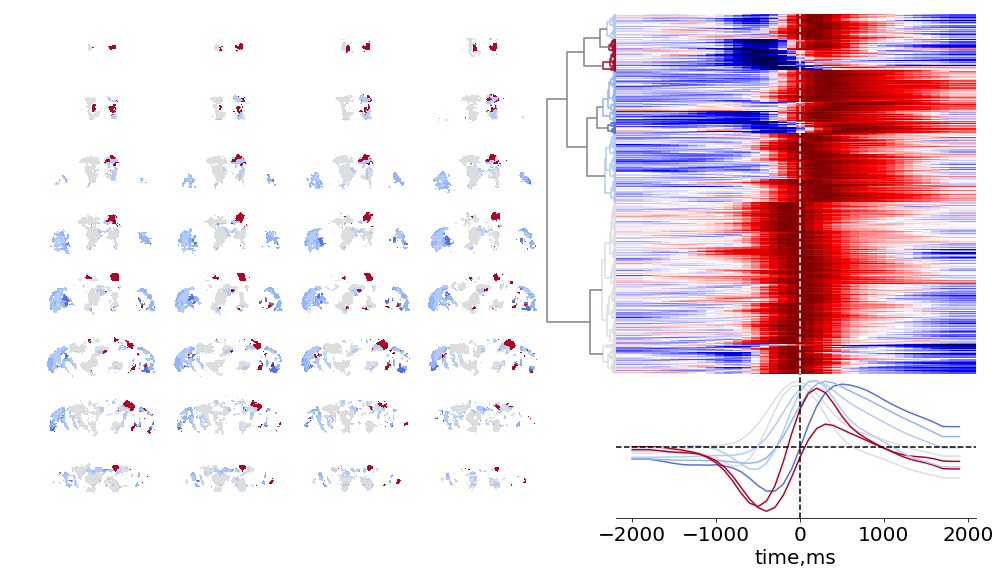

In [109]:
fig = plt.figure(figsize=(10,10))

### dendrogram ###
ax_dendrogram = fig.add_axes([1, .3, .1, .5])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

### all resp ###
ax_dend = fig.add_axes([1.1, .3, .5, .5])
aspect = signals_for_clustering.shape[1]/signals_for_clustering.shape[0]
ax_dend.imshow(signals_for_clustering[dend['leaves'][::-1],:],vmin=-1,vmax=1,aspect=aspect,cmap='seismic')
ax_dend.axis('off')
for line in [20]:
    ax_dend.axvline(line,color='w',linestyle='--')    
#plt.title('top 25% fwd, ward, normalized')

### Mean resp ###
ax = fig.add_axes([1.1, 0.1, .5, .2])
timepoints = list(range(-2000,0,100)) + list(range(0,2000,100))
#timepoints = list(range(-2500,0,100)) + list(range(0,2500,100))

for n in range(len(np.unique(cluster_ids))):
    ax.plot(timepoints, cluster_responses[n],color=cluster_colors[n])
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.set_xlabel('time,ms')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### BRAIN ###
grid = ImageGrid(fig, rect=[.3,.1,.7,.7], nrows_ncols=(8, 4), axes_pad=.05)
for j,i in enumerate(range(8,49-9)):
    #grid[j].imshow(out['warpedmovout'].numpy()[:,:,i].T,cmap='gray')
    cax = grid[j].imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
for i in range(32):
    grid[i].axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

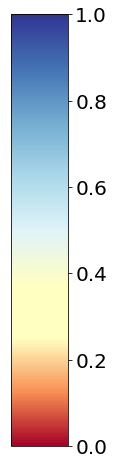

In [188]:
a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=spectral_map)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

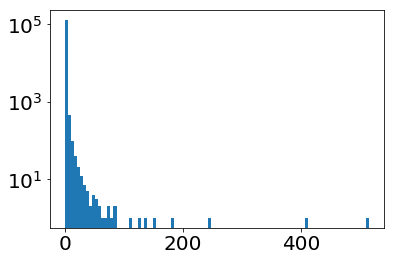

In [16]:
plt.hist(model.distances_,bins=100,log=True);

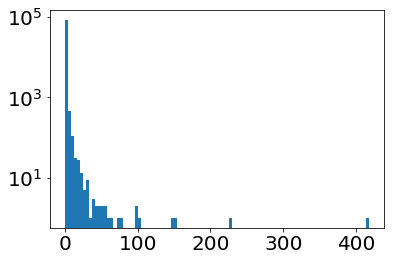

In [28]:
plt.hist(model.distances_,bins=100,log=True);

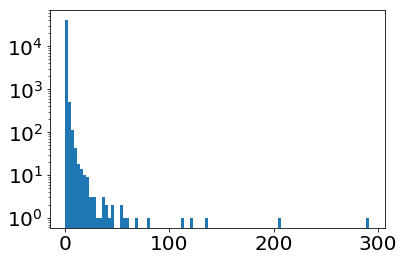

In [39]:
plt.hist(model.distances_,bins=100,log=True);

In [40]:
# 8 clusters give about the same thresh for each model so lets do that

69.39852901322112

In [39]:
import glob

In [48]:
pattern = '*.ipynb'
query = '20210707-034306'
query = '20210707-034306_fwd_inv_warp'

for filepath in glob.iglob(pattern, recursive=True):
    with open(filepath) as file:
        s = file.read()
        if (s.find(query) > -1):
            print(filepath)

20210713 - aws nn filters mirror cleaning and clustering - fwd and wlk.ipynb
20210721 - AWS Filters Clustering - Rot.ipynb


In [40]:
os.listdir('.')

['20200807 - Closer look at within-fly single anat vol alignment.ipynb',
 '20200130 - onset offset walking explore baseline options.ipynb',
 'Anatomy alignment-Dec28th.ipynb',
 '20200531 - super voxels cluster outlines fig.ipynb',
 '20200524 - super voxels.ipynb',
 '20210722 - cutting rois into groups.ipynb',
 '20210216 - view results insta unique glms single reconstructed.ipynb',
 '20201207 - Bootstrap maps.ipynb',
 '20210515 - prep_data_for_aws-Copy1.ipynb',
 '20210729 - voxel corr types per atlas roi.ipynb',
 '20191208 - Inspect CMTK individual warp (including mirror) to meanbrain20191206.ipynb',
 '20200612 - super voxel full brain summary figures.ipynb',
 '20190805 - Exploring Behavior Triggers.ipynb',
 '20210601 - temporal filter normalized by autocorr for steve.ipynb',
 '20191223 - clustered_UMAP(2D)_with_behavior_video.ipynb',
 '20201207 - Bootstrap maps (backup).ipynb',
 '20201229 - Figures of single anat alignment quality.ipynb',
 '20210511 - temporal glm to fit filters.ipynb'